In [2]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

In [3]:
# Gets src path 
src_path = os.path.dirname(os.getcwd())

# Adds src_path if it doesn't exist in sys.path (to access utils)
if os.path.exists(src_path) and src_path not in sys.path:
    sys.path.append(src_path)
    
import src.utils.data_tools as dt
import src.utils.viz_tools as vt

In [4]:
df_main = pd.read_csv('./src/data/processed/main_data.csv')
df_bm = pd.read_csv('./src/data/processed/biomarker_data.csv')
df_adni = pd.read_csv('./src/data/processed/adni_data.csv')

df_main['Education_lv'] = df_main['Education_lv'].fillna('None')

### Data for testing

In [274]:
main_clasif = dt.classify_by_cardinality(df_main)
column_selection = main_clasif.loc[main_clasif['Suggested Type'].isin(['Binary', 'Categorical'])]
categorical = column_selection.index.to_list()

new_labels = {
    'Gender': ['Male', 'Female'],
    'Ethnicity': ['Caucasian', 'African American', 'Asian', 'Other'],
    'Education_lv': ['None', 'High School', 'Bachelor\'s', 'Higher'],
    'Smoking': ['No', 'Yes'],
    'Family_History_Alzheimers': ['No', 'Yes'],
    'CVD': ['No', 'Yes'],
    'Diabetes': ['No', 'Yes'],
    'Depression': ['No', 'Yes'],
    'Head_Injury': ['No', 'Yes'],
    'Hypertension': ['No', 'Yes'],
    'Memory_Complaints': ['No', 'Yes'],
    'Behavioral_Problems': ['No', 'Yes'],
    'Confusion': ['No', 'Yes'],
    'Disorientation': ['No', 'Yes'],
    'Personality_Changes': ['No', 'Yes'],
    'Difficulty_Completing_Tasks': ['No', 'Yes'],
    'Forgetfulness': ['No', 'Yes'],
    'DX': ['No AD', 'AD']
}

In [6]:
bm_classification = dt.classify_by_cardinality(df_bm)
column_selection = bm_classification.loc[bm_classification['Suggested Type'].isin(['Binary', 'Categorical'])]
categorical_bm = column_selection.index.to_list()

new_labels = {
    'Gender': ['Male', 'Female'],
    'Smoking': ['No', 'Yes'],
    'Drinking': ['No', 'Yes'],
    'CVD': ['No', 'Yes'],
    'Hypertension': ['No', 'Yes'],
    'Diabetes': ['No', 'Yes'],
    'DX': ['CU', 'MCI', 'AD']
}

### Categorical functions

In [277]:
def plot_categorical_distribution(df, cat_columns, n_columns = 3, *, relative = False, show_values = False, custom_labels = False, rotation = 45, palette = 'viridis'):
    '''   
    Generates bar plots to visualize the distribution of categorical variables in a given DataFrame. The function allows for plotting either the absolute or relative frequencies of the categories for each specified column. Additionally, it provides options to display frequency values directly on the bars, apply custom labels, rotate the x-axis labels, and choose a color palette. The layout of the plots is automatically adjusted based on the number of columns specified by the user.

    Parameters:
        df (pd.DataFrame): 
            DataFrame containing the data to plot. It should include the categorical columns specified in `cat_columns`.
        
        cat_columns (list of str): 
            List of column names (strings) corresponding to the categorical variables to visualize.
        
        n_columns (int, optional, default=3):
            Number of columns for the subplot grid. This value can be 1, 2, or 3. If the number of categorical columns (`cat_columns`) is fewer than `n_columns`, the grid will automatically adjust to use the exact number of columns needed. 

        relative (bool, optional, default=False): 
            If True, the function will plot the relative frequencies of the categories. If False, it will plot the absolute frequencies.

        show_values (bool, optional, default=False): 
            If True, the function will display the frequency values directly on top of the bars in the plot.

        custom_labels (dict of {str: list}, optional, default=False): 
            If provided, this dictionary should map column names to lists of custom labels to use for the x-axis ticks. The keys should be column names from `cat_columns`, and the values should be lists of labels corresponding to the categories in that column.

        rotation (int, optional, default=45): 
            Angle (in degrees) to rotate the x-axis labels for better readability.

        palette (str, optional, default='viridis'): 
            Color palette to use for the bars. If an empty string is provided, 'viridis' will be used as the default.

    Returns:
        None: 
            This function does not return any objects. It generates and displays a set of bar plots showing the frequency distributions of the specified categorical variables.
    '''

    # Validate number of specified columns
    if n_columns not in [1, 2, 3]:
        raise ValueError('n_columns must be 1, 2 or 3.')
    
    # Determine the number of columns and rows needed for the subplot grid
    n_plots = len(cat_columns)
    if n_plots in [1, 2]:
        n_columns = n_plots
    n_rows = (n_plots // n_columns) + (1 if n_plots % n_columns != 0 else 0)
    
    # Create the base figure and a grid of subplots with the specified size
    fig, axs = plt.subplots(n_rows, n_columns, figsize = (5 * n_columns, 6 * n_rows))
    axs = axs.flatten() if n_plots > 1 else [axs]
    
    # Set figure title and update palette if string is empty
    plt.suptitle('Categorical Distribution', ha = 'center', y = 1, fontproperties = {'weight': 600, 'size': 14})
    
    if palette == '':
        palette = 'viridis'
    
    # Plot the frequency distribution for each categorical column
    for i, col in enumerate(cat_columns):
        ax = axs[i]
        if relative:
            # Calculate and plot the relative frequencies
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x = serie.index, y = serie, ax = ax, palette = palette, hue = serie.index, legend = False)
            ax.set_ylabel('Relative Frequency')
        else:
            # Calculate and plot the absolute frequencies
            serie = df[col].value_counts()
            sns.barplot(x = serie.index, y = serie, ax = ax, palette = palette, hue = serie.index, legend = False)
            ax.set_ylabel('Count')

        # Set the title, ticks, grid and spine
        ax.set_title(f'{col}', ha = 'center', y = 1.025)
        ax.set_xlabel('')
        ax.tick_params(colors = '#565656')
        ax.tick_params(axis = 'x', rotation = rotation, colors = 'k')
        ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
        ax.set_axisbelow(True)
        ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
        
        if custom_labels:
            # Set custom labels
            labels = custom_labels[col]
            ticks = range(len(labels))
            ax.set_xticks(ticks = ticks, labels = labels)

        if show_values:
            # Annotate each bar with its height (the frequency value)
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}' if relative else f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
                
    # Hide any unused subplots if the number of categorical columns is odd
    for j in range(i + 1, n_rows * n_columns):
        axs[j].axis('off')
        
    # Adjust the layout to prevent overlap and display the plots
    plt.tight_layout(h_pad = 3, w_pad = 5)
    plt.show()

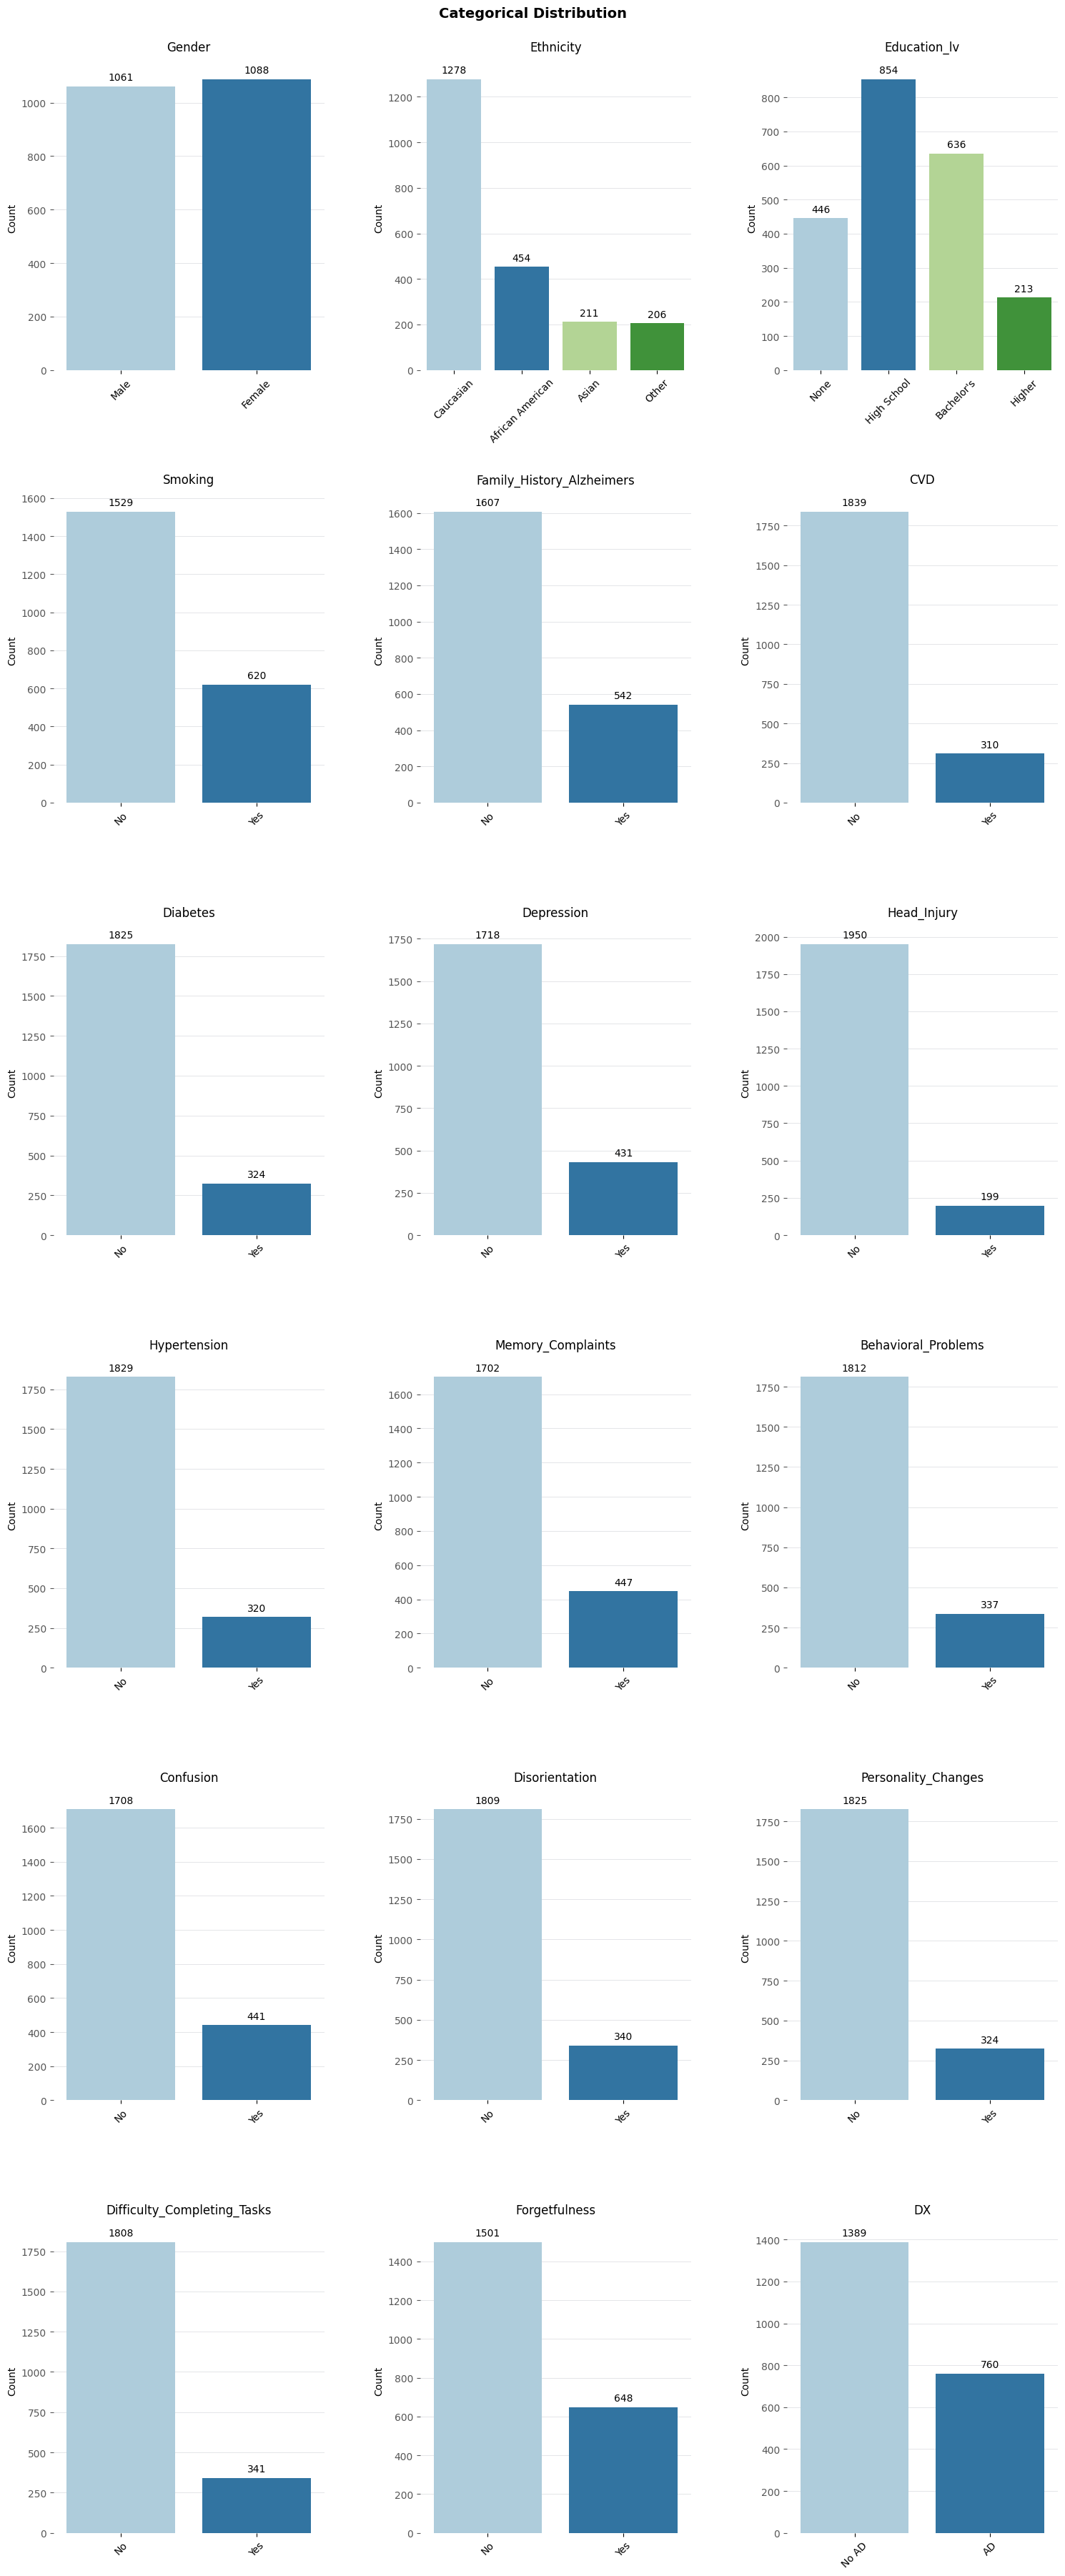

In [278]:
plot_categorical_distribution(df_main, categorical, custom_labels=new_labels, palette = 'Paired', show_values=True)

### Relationships

In [268]:
def plot_categorical_relationship(df, cat_col1, cat_col2, *, relative = False, show_values = False, size_group = 5, rotation = 45, palette = 'viridis'):
    '''
    Generates bar plots to visualize the relationship between two categorical columns in a DataFrame. It also shows the frequency (or relative frequency) of each combination of categories in `cat_col1` and `cat_col2`. 
    If there are too many categories in `cat_col1`, the plot is divided into multiple subplots for better visualization. Additionally, it can rotate x-axis labels and display values on the bars if requested.

    Parameters:
        df (pd.DataFrame): 
            The DataFrame containing the data for the plot.
        cat_col1 (str): 
            The name of the categorical column in the DataFrame to be used for the x-axis.
        cat_col2 (str): 
            The name of the categorical column in the DataFrame to differentiate the bars in the plot (through color).
        relative (bool, optional): 
            If True, frequencies will be displayed as relative proportions instead of absolute counts. Default is False.
        show_values (bool, optional): 
            If True, values will be annotated on top of the bars. Default is False.
        size_group (int, optional): 
            Maximum number of categories to display in a single plot. If there are more categories, they will be split into multiple plots. Default is 5.
        rotation (int, optional): 
            Angle of rotation for x-axis labels. Default is 45 degrees.
        palette (str, optional): 
            Color palette to use in the plot. Default is 'viridis'. If set to an empty string, the default Seaborn palette will be used.

    Returns:
        None: The function displays the plot and does not return any value.
    '''
    
    # Prepare the data
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name = 'count')
    total_counts = df[cat_col1].value_counts()
    
    # Calculate relative frequencies if specified
    if relative:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis = 1)
    
    if palette == '':
        palette = 'viridis'

    # If there is more than size_group categories in cat_col1, they get divided into size_group groups
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Select subgroup of categories for each plot
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Create plot
            plt.figure(figsize = (10, 6))
            ax = sns.barplot(x = cat_col1, y = 'count', hue = cat_col2, data = data_subset, order = categories_subset, palette = palette)
            
            # Set the title, ticks, grid and spine
            ax.set_title(f'Relationship between {cat_col1} and {cat_col2} - Group {i + 1}')
            ax.set_xlabel(cat_col1)
            ax.set_ylabel('Relative Frequency' if relative else 'Count')
            ax.tick_params(colors = '#565656')
            ax.tick_params(axis = 'x', rotation = rotation, colors = 'k')
            ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
            ax.set_axisbelow(True)
            ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

            if show_values:
                # Annotate each bar with its height (the frequency value)
                for p in ax.patches:
                    if p.get_xy() != (0,0):
                        height = p.get_height()
                        ax.annotate(f'{height:.2f}' if relative else f'{height:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                    ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, size_group),
                                    textcoords = 'offset points')

            # Display plots
            plt.show()
    else:
        # Creates plot for less than size_group categories
        plt.figure(figsize = (10, 6))
        ax = sns.barplot(x = cat_col1, y = 'count', hue = cat_col2, data = count_data, palette = palette)
        
        # Set the title, ticks, grid and spine
        ax.set_title(f'Relationship between {cat_col1} and {cat_col2}')
        ax.set_xlabel(cat_col1)
        ax.set_ylabel('Relative Frequency' if relative else 'Count')
        ax.tick_params(colors = '#565656')
        ax.tick_params(axis = 'x', rotation = rotation, colors = 'k')
        ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
        ax.set_axisbelow(True)
        ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

        if show_values:
            # Annotate each bar with its height (the frequency value)
            for p in ax.patches:
                if p.get_xy() != (0,0):
                    height = p.get_height()
                    ax.annotate(f'{height:.2f}' if relative else f'{height:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, size_group),
                                textcoords = 'offset points')
        # Legend
        legend = plt.legend(title = cat_col2, title_fontsize = 'small', framealpha = 1, fontsize = 'small', edgecolor = '#565656', borderpad = 1, loc = 'best')
        legend.get_frame().set_linewidth(0.8)
  
        # Display plot
        # plt.tight_layout()
        plt.show()


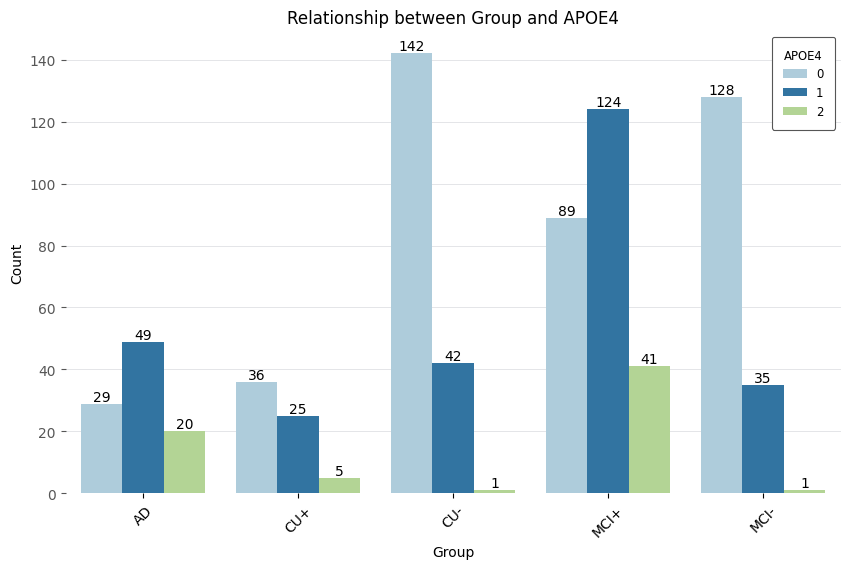

In [269]:
plot_categorical_relationship(df_adni, 'Group', 'APOE4', relative=False, show_values = True,palette = 'Paired')

### Numerical functions

In [10]:
bm_classification = dt.classify_by_cardinality(df_bm)
column_selection = bm_classification.loc[bm_classification['Suggested Type'].isin(['Numerical (discrete)', 'Numerical (continuous)'])]
numerical_bm = column_selection.index.to_list()
numerical_bm

['Age',
 'BMI',
 'Education_yrs',
 'MMSE',
 'MOCA',
 'Plasma_GFAP',
 'Plasma_NfL',
 'Plasma_ptau181']

In [93]:
def plot_combined_histogram_boxplot(df, columns, *, kde = True, boxplot = False, whisker_width = 1.5, bins = None):
    n_columns = len(columns)
    if n_columns:
        # Create base figure and a grid of subplots (1 or 2 columns depending on boxplot specification)
        if not boxplot:
            fig, axs = plt.subplots(n_columns, 1, figsize = (8, 6 * n_columns))
        else:
            fig, axs = plt.subplots(n_columns, 2, figsize = (12, 6 * n_columns))
        
        axs = np.atleast_1d(axs).flatten()
        
        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histogram and KDE
                ax = axs[i * (2 if boxplot else 1)]
                sns.histplot(df[column], kde = kde, ax = ax, bins = 'auto' if not bins else bins)
                ax.set_title(f'Histogram and KDE of {column}' if kde else f'Histogram of {column}')
                ax.tick_params(colors = '#565656')
                # ax.grid(axis = 'y', color = '#CFD2D6', linewidth = 0.4)
                ax.set_axisbelow(True)
                ax.spines[['right', 'top']].set_visible(False)
                ax.spines[['left', 'bottom']].set_color('#565656')
               

                # Boxplot
                if boxplot:
                    ax = axs[i * 2 + 1]
                    sns.boxplot(x = df[column], ax = ax, whis = whisker_width)
                    ax.set_title(f'Boxplot of {column}')
                    ax.tick_params(colors = '#565656')
                    ax.spines[['right', 'top', 'left']].set_visible(False)
                    ax.spines[['bottom']].set_color('#565656')
                    
        
        plt.suptitle('Histograms and Boxplots' if boxplot else  'Histograms', ha = 'center', y = 1, fontproperties = {'weight': 600, 'size': 14})
        plt.tight_layout(h_pad = 3, w_pad = 3)
        plt.show()

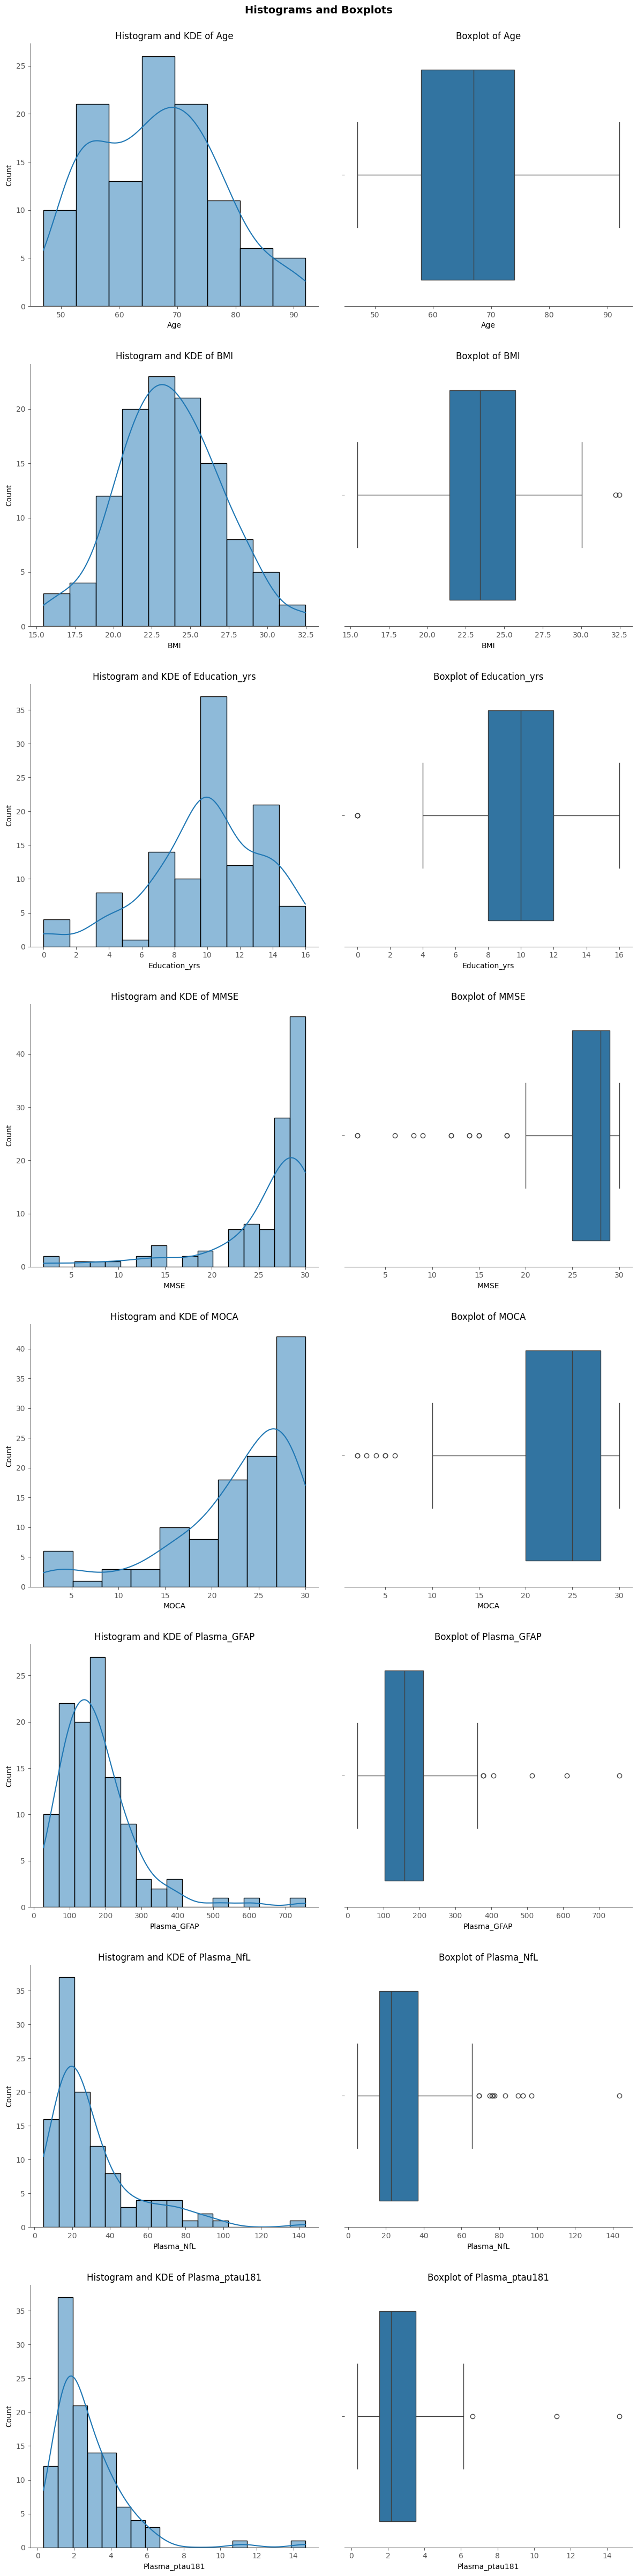

In [95]:
plot_combined_histogram_boxplot(df_bm, numerical_bm, kde = True, boxplot = True)

### REVIEW AND UPDATE

In [ ]:
def custom_scatter_plot(df, x, y, color_col = None, size_col = None, scale = 1, legend = 'auto'):
    fig, ax = plt.subplots(figsize = (20, 10))
        
    # Scatter plot
    if type(size_col) == str:
        if size_col != '':
            if color_col:
                sp = plt.scatter(x = df[x], y = df[y], c = df[color_col], s = df[size_col] * scale, cmap = 'viridis', alpha = 0.5)
            else:
                sp = plt.scatter(x = df[x], y = df[y], s = df[size_col] * scale, cmap = 'viridis', alpha = 0.5)
        elif color_col:
            sp = plt.scatter(x = df[x], y = df[y], c = df[color_col], cmap = 'viridis', alpha = 0.5)
    else:
        plt.scatter(x = df[x], y = df[y], s = df[size_col] * scale, cmap = 'viridis', alpha = 0.5)
    
    # Legend
    handles, labels = sp.legend_elements('sizes', num = 6)
    for handle in handles:
        handle.set_markerfacecolor('#CCCCCC')
        handle.set_markeredgecolor('#CCCCCC')
    
    if legend == 'colorbar':
        plt.legend(handles, labels, ncol = 3, title = size_col, title_fontsize = 'small', fontsize = 'small', frameon = False, loc = 'upper right', labelspacing = 2)
        plt.colorbar(label = f'{color_col}')
        # plt.clim(df[color_col].min(), df[color_col].max()) # No hacer esto, porque tendría en cuenta los outliers y descolocaría el resto de colores
        plt.clim(0, 7)
    else:  
        plt.legend(handles, labels, ncol = 3, title = size_col, title_fontsize = 'small', fontsize = 'small', frameon = False, loc = 'upper right', labelspacing = 2)
    
    # Figure presentation
    if legend == 'colorbar': # This fixes title horizontal alignment (not centered in colorbar option)
        plt.suptitle(f'Scatter plot: {x}, {y}{(f', {color_col}') if color_col else ''}{(f', {size_col}') if size_col else ''}', x = 0.47, y = 0.92, weight = 'bold') 
    else:
        plt.suptitle(f'Scatter plot: {x}, {y}{(f', {color_col}') if color_col else ''}{(f', {size_col}') if size_col else ''}', x = 0.5, y = 0.92, weight = 'bold')
        
    plt.xlabel(x)
    plt.ylabel(y)
    ax.spines[['top', 'right', 'bottom', 'left']].set_color('#d3d3d3')
    ax.tick_params(colors = '#565656')

In [ ]:
def edu_clasif(years):
    if years > 18:
        level = 'Higher'
    elif years >= 16:
        level = 'Bachelors'
    elif years >= 12:
        level = 'High School'
    else:
        level = 'None'
    return level

In [ ]:
def bar_donut_chart(df, variable):
    colors = ['#6CB4EE', '#318CE7', '#6495ED', '#87CEFA'] 

    category_counts = df[variable].value_counts()

    fig, axs = plt.subplots(1, 2, figsize = (14, 4)) 

    bars = axs[0].barh(category_counts.index, category_counts.values, color = colors)
    axs[0].set_title(f'{variable} Distribution', fontsize = 16)
    axs[0].set_xlabel('Count')
    axs[0].set_ylabel(f'{variable} Types')

    for bar, value in zip(bars, category_counts.values):
        width = bar.get_width()
        axs[0].text(width, bar.get_y() + bar.get_height() / 2, '%d' % int(width),
                    ha = 'left', va = 'center', color = 'black', fontsize = 10)

    status_counts = df[variable].value_counts()

    wedges, texts, autotexts = axs[1].pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)

    centre_circle = plt.Circle((0,0),0.70,fc = 'white')
    plt.gca().add_artist(centre_circle)
    axs[1].axis('equal')

    plt.tight_layout()
    plt.show()